<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#DecisionTreeClassifier" data-toc-modified-id="DecisionTreeClassifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>DecisionTreeClassifier</a></span></li><li><span><a href="#CatBoostClassifier" data-toc-modified-id="CatBoostClassifier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>CatBoostClassifier</a></span></li><li><span><a href="#Проверка-лучшей-модели-на-тестовой-выборке" data-toc-modified-id="Проверка-лучшей-модели-на-тестовой-выборке-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Проверка лучшей модели на тестовой выборке</a></span><ul class="toc-item"><li><span><a href="#Вывод:-Логистическая-регрессия-полностью-подходит-,-данное-утерждение-подтверждается-проверкой-на-тестовой-выборке." data-toc-modified-id="Вывод:-Логистическая-регрессия-полностью-подходит-,-данное-утерждение-подтверждается-проверкой-на-тестовой-выборке.-2.4.1"><span class="toc-item-num">2.4.1&nbsp;&nbsp;</span>Вывод: Логистическая регрессия полностью подходит , данное утерждение подтверждается проверкой на тестовой выборке.</a></span></li></ul></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. 

Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
!pip install spacy
!pip install en_core_web_sm

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import nltk
import re
from nltk.corpus import stopwords as st
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords as nltk_stopwords
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('russian'))
import spacy
# Install spaCy (run in terminal/prompt)
import sys

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from tqdm import tqdm
from sklearn.utils import shuffle
import torch
import transformers
from tqdm import notebook

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier

import random
from sklearn.metrics import f1_score
import nltk
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
!{sys.executable} -m pip install spacy
# Download spaCy's  'en' Model
!{sys.executable} -m spacy download en
nlp = spacy.load('en_core_web_sm')

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     |████████████████████████████████| 13.9 MB 1.3 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [4]:
try:
    df = pd.read_csv('/datasets/toxic_comments.csv')
except:
    df = pd.read_csv('toxic_comments.csv')
display(df)
df.info() 

Unnamed: 0                                               text  toxic
0                0  Explanation\nWhy the edits made under my usern...      0
1                1  D'aww! He matches this background colour I'm s...      0
2                2  Hey man, I'm really not trying to edit war. It...      0
3                3  "\nMore\nI can't make any real suggestions on ...      0
4                4  You, sir, are my hero. Any chance you remember...      0
...            ...                                                ...    ...
159287      159446  ":::::And for the second time of asking, when ...      0
159288      159447  You should be ashamed of yourself \n\nThat is ...      0
159289      159448  Spitzer \n\nUmm, theres no actual article for ...      0
159290      159449  And it looks like it was actually you who put ...      0
159291      159450  "\nAnd ... I really don't think you understand...      0

[159292 rows x 3 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
Данные загружены и исследованы.</div>

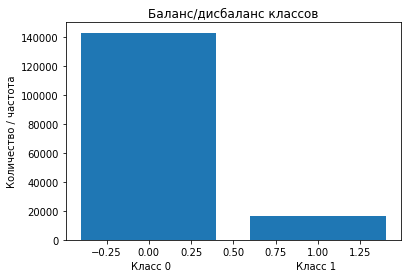

In [5]:
figsize=(18,15)
class_counts = df['toxic'].value_counts()
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Класс 0                                        Класс 1')
plt.ylabel('Количество / частота')
plt.title('Баланс/дисбаланс классов');

In [6]:
#Посмотрим сколько у нас токсичных/нектоксичных текстов
display(df['toxic'].value_counts())
#Выведем соотношение
class_ratio = df['toxic'].value_counts()[0] / df['toxic'].value_counts()[1]
class_ratio

0    143106
1     16186
Name: toxic, dtype: int64

8.841344371679229

На первом этапе произведена загрузка данных и их подготовка для обучения моделей.

В столбце text содержащатся комментарии пользователей к товарам, доступным для приобретения в интернет-магазине «Викишоп».

Пропуски в данных отсутствуют.

Сделаем 2 небольших вывода: 

- столбец Unnamed: 0 - необходимо удалить так как он дублирует нумирацию индексов;

- превосходство класса 0 в столбце toxic значительно, в 8,84 раза, классы не сбалансированы.

In [7]:
df = df.drop(['Unnamed: 0'], axis=1)


In [8]:
disabled_pipes = [ "parser",  "ner"]

In [9]:
nlp = spacy.load('en_core_web_sm', disable=disabled_pipes)
lemm_texts = []

for doc in tqdm(nlp.pipe(df['text'].values, disable = ['ner', 'parser']), total=df.shape[0]):
    lemm_text = " ".join([i.lemma_ for i in doc]) 
    lemm_text  = re.sub(r'[^a-zA-Z]', ' ', lemm_text)
    lemm_text = lemm_text.lower()
    lemm_texts.append(lemm_text) 

100%|██████████| 159292/159292 [11:08<00:00, 238.17it/s]


In [10]:
lemm_texts

['explanation   why the edit make under my username hardcore metallica fan be revert   they be not vandalism   just closure on some gas after i vote at new york dolls fac   and please do not remove the template from the talk page since i be retire now             ',
 'd aww   he match this background colour i be seemingly stuck with   thank       talk           january             utc  ',
 'hey man   i be really not try to edit war   it be just that this guy be constantly remove relevant information and talk to i through edit instead of my talk page   he seem to care more about the formatting than the actual info  ',
 '    more   i can not make any real suggestion on improvement   i wonder if the section statistic should be later on   or a subsection of     type of accident        i think the reference may need tidy so that they be all in the exact same format ie date format etc   i can do that later on   if no   one else do first   if you have any preference for format style on refere

In [11]:
df['lemm_text'] = pd.Series(lemm_texts)

In [12]:
df = df.drop('text', axis=1)
df

toxic                                          lemm_text
0           0  explanation   why the edit make under my usern...
1           0  d aww   he match this background colour i be s...
2           0  hey man   i be really not try to edit war   it...
3           0      more   i can not make any real suggestion ...
4           0  you   sir   be my hero   any chance you rememb...
...       ...                                                ...
159287      0              and for the second time of asking ...
159288      0  you should be ashamed of yourself    that be a...
159289      0  spitzer    umm   there s no actual article for...
159290      0  and it look like it be actually you who put on...
159291      0      and     i really do not think you understa...

[159292 rows x 2 columns]

In [13]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Далее делим на фичи и таргет (обучающая и тестовая выборки). После этого выполняем векторизацию. Для этого потребуется TfidfVectorizer(). 

На обучающей выборке обучаем и выполняем преобразованием, т. е. делаем .fit_transform(features_train), а на тестовой только преобразование, т. е. .transform(features_test).

In [14]:
# Разделим выборку train, test 
# Уменьшим количество кроссвалидаций чтобы код не работал слишком медленно
target = df['toxic']
features = df.drop(['toxic'], axis=1)

features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                              target, 
                                                                              test_size=0.1, 
                                                                              random_state=12345)

stopwords = set(nltk_stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=stopwords)

features_train = count_tf_idf.fit_transform(features_train['lemm_text'].values)
features_test = count_tf_idf.transform(features_test['lemm_text'].values) #  здесь фит не нужен так как это тестовая выборка
print(features_train.shape)
print(features_test.shape)
my_cv = 2

(143362, 147653)
(15930, 147653)


In [15]:
classificator = LogisticRegression()
f1 = cross_val_score(classificator, 
                      features_train, 
                      target_train, 
                      cv=my_cv, 
                      scoring='f1').mean()
print('F1 на CV', f1)

F1 на CV 0.6964515715113593


In [16]:
dict_classes={0:1, 1:class_ratio}

**Вывод:**
- данные лемметизированы;
- выборки созданы;
- результат F1 score - ниже нормы - сбалансируем данные.

**Вывод**

На первом этапе произведена загрузка данных и их подготовка для обучения моделей. 

Датасет состоит из 2 столбцов 

text — текст комментария;

toxic — является ли комментарий токсичным (1) или не таксичным (0)



Cформированы обучающая и тестовая выборка.


## Обучение


В качестве моделей будем использовать Логистическую регрессию, DecisionTreeClassifier и CatBoost классификатор.



### LogisticRegression

In [18]:
%%time
classificator = LogisticRegression(fit_intercept=True,  
                                   random_state=12345,
                                   class_weight=dict_classes)
hyperparams = [{'solver':['newton-cg', 'lbfgs', 'liblinear'],
                'C':[0.1, 1, 10]}]

#Применяю GridSearchCV с кросс-валидацией
regression_grid = GridSearchCV(classificator, hyperparams, scoring='f1', cv=my_cv)
regression_grid.fit(features_train, target_train)

classificator.fit(features_train, target_train)
regression_cv_score = cross_val_score(classificator,features_train, target_train,scoring='f1',cv=my_cv).mean()
print('Среднее F-меры на кросс-валидации:', regression_cv_score)


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Среднее F-меры на кросс-валидации: 0.7534015570346786
CPU times: user 4min 42s, sys: 5min 41s, total: 10min 23s
Wall time: 10min 24s


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [19]:
%%time
#посмотрим на лучшие параметры
classificator_params = regression_grid.best_params_
classificator_score = regression_grid.score(features_train, target_train)
print(classificator_params)
print(classificator_score)


{'C': 10, 'solver': 'liblinear'}
0.9226707383020007
CPU times: user 57.4 ms, sys: 0 ns, total: 57.4 ms
Wall time: 91.5 ms


**Подитог**: Данная модель прошла минимальный порог F меры в 0,75 и пока нам подходит для рассмотрения.

**Результаты утешительные - смотрим дальше на следующие модели**

### DecisionTreeClassifier

In [20]:
%%time
classificator = DecisionTreeClassifier()
hyperparams = [{'max_depth':range(4, 70, 10),
                'random_state':[12345],
                'class_weight':[dict_classes]}]


print('# Гиперпараметры для f1_score')
print()
clf = GridSearchCV(classificator, hyperparams, scoring='f1',cv=my_cv)
clf.fit(features_train, target_train)
print("Лучший набор параметров по данной модели:")
print()
DTC_best_params = clf.best_params_
print(DTC_best_params)


# Гиперпараметры для f1_score

Лучший набор параметров по данной модели:

{'class_weight': {0: 1, 1: 8.841344371679229}, 'max_depth': 64, 'random_state': 12345}
CPU times: user 5min 23s, sys: 3.88 s, total: 5min 26s
Wall time: 5min 27s


In [21]:
classificator_score = clf.score(features_train, target_train)
print(classificator_score)

0.8292466664393139


In [22]:
%%time
regression_cv_score = cross_val_score(clf,features_train, target_train,scoring='f1',cv=my_cv).mean()
print('Среднее F-меры на кросс-валидации:', regression_cv_score)

Среднее F-меры на кросс-валидации: 0.6254178969900539
CPU times: user 4min 14s, sys: 2.77 s, total: 4min 16s
Wall time: 4min 17s


In [23]:
# %%time
# #Обучим DecisionTreeClassifier на оптимальных гиперпараметрах:


# classificator = DecisionTreeClassifier(random_state=12345, class_weight=[dict_classes],
#                                      max_depth=64)
# classificator.fit(features_train, target_train)

In [24]:
print()
print("Оценки гридсерч:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))
print()

cv_f1_DTC = max(means)


Оценки гридсерч:

0.238126 for {'class_weight': {0: 1, 1: 8.841344371679229}, 'max_depth': 4, 'random_state': 12345}
0.605500 for {'class_weight': {0: 1, 1: 8.841344371679229}, 'max_depth': 14, 'random_state': 12345}
0.594385 for {'class_weight': {0: 1, 1: 8.841344371679229}, 'max_depth': 24, 'random_state': 12345}
0.613644 for {'class_weight': {0: 1, 1: 8.841344371679229}, 'max_depth': 34, 'random_state': 12345}
0.618333 for {'class_weight': {0: 1, 1: 8.841344371679229}, 'max_depth': 44, 'random_state': 12345}
0.628204 for {'class_weight': {0: 1, 1: 8.841344371679229}, 'max_depth': 54, 'random_state': 12345}
0.634489 for {'class_weight': {0: 1, 1: 8.841344371679229}, 'max_depth': 64, 'random_state': 12345}



In [25]:
classificator = DecisionTreeClassifier()
classificator.set_params(**DTC_best_params)

print('F1 на cv', cv_f1_DTC)

F1 на cv 0.6344888840271425


**Подитог** Что усредненно что на лучшей моделе F1 мера ниже нормы - модель не подходит.

### CatBoostClassifier

In [1]:
%%time
classificator = CatBoostClassifier(verbose=False, iterations=100)
classificator.fit(features_train, target_train)
cv_f1_CBC = cross_val_score(classificator,
                            features_train, 
                            target_train, 
                            cv=my_cv, 
                            scoring='f1').mean()

print('F1 на cv', cv_f1_CBC)


NameError: name 'CatBoostClassifier' is not defined

**Вывод**

Как можно заметить худший результат показала модель DecisionTreeClassifier. 

Близка к нужному значение метрки F1 CatBoostClassifier с значение на кросвалидации 0.733 - но долгая и нужно подбирать параметры.

Ввиду этого выбрана модель для проверки на тестовом наборе данных по скорости работы и качеству  : LogisticRegression

### Проверка лучшей модели на тестовой выборке

In [34]:
%%time
regression_model = LogisticRegression(fit_intercept=True,
                                class_weight='balanced',
                                random_state=12345,
                                solver='liblinear',
                                C=classificator_params['C']
                               )
regression_model.fit(features_train, target_train)
regression_model_predictions = regression_model.predict(features_test)

CPU times: user 14 s, sys: 13.2 s, total: 27.2 s
Wall time: 27.2 s


In [35]:
regression_f1 = round(f1_score(target_test, regression_model_predictions), 4) 
print(regression_f1)

0.7667


#### Вывод: Логистическая регрессия полностью подходит , данное утерждение подтверждается проверкой на тестовой выборке.

## Выводы


Было прделано:


- Лемитизирован и очищен текст от ненужных символов 
- Cформированы обучающая и тестовая выборка.
- Обучены модели и выбрана лучшая из них на кросвалидации.
- Лучшая модель стала LogisticRegression - результат метрики F1 выше заданных в задаче 0.75 

CatBoostClassifier может рабоать лучше но при большей кол-ве итераций и соответственно большем потраченном времени.